# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: 

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [53]:
# Define transforms (you can modify these based on your needs)
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # First resize the image
        transforms.ToTensor(),  # Then convert to tensor (must come before normalize)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Finally normalize
    ]
)

# set the Lab3/Lab3 Dataset/Lab3_Gestures_Summer/ as the ImageFolder root
images = torchvision.datasets.ImageFolder(
    "./Lab3 Dataset/Lab3_Gestures_Summer/", transform=transform
)
num_classes = len(images.classes)

In [54]:
# divide the data into training, validation and test sets
# 80% training, 10% validation, 10% test
n = len(images)
n_train = int(0.8 * n)
n_val = n_test = (n - n_train) // 2
train_data, val_data, test_data = torch.utils.data.random_split(
    images, [n_train, n_val, n_test]
)
# print the size of each set
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 1775
Validation set size: 222
Test set size: 222


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [55]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # First Convolutional Layer
        # Input: batch x 3 x 224 x 224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Output: batch x 6 x 220 x 220 ((224 - 5 + 0)/1 + 1 = 220)

        # First Max Pooling Layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: batch x 6 x 110 x 110 (220/2 = 110)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # Output: batch x 16 x 106 x 106 ((110 - 5 + 0)/1 + 1 = 106)

        # Second Max Pooling Layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: batch x 16 x 53 x 53 (106/2 = 53)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        # Output: batch x 32 x 49 x 49 ((53 - 5 + 0)/1 + 1 = 49)

        # Calculate the input features for the first fully connected layer
        self.fc1 = nn.Linear(32 * 49 * 49, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # Replace num_classes with actual number

    def forward(self, x):
        # Input shape: batch x 3 x 224 x 224
        x = self.pool1(F.relu(self.conv1(x)))
        # Shape: batch x 6 x 110 x 110

        x = self.pool2(F.relu(self.conv2(x)))
        # Shape: batch x 16 x 53 x 53

        x = F.relu(self.conv3(x))
        # Shape: batch x 32 x 49 x 49

        # Flatten the tensor
        x = x.view(-1, 32 * 49 * 49)
        # Shape: batch x 76,832 (32 * 49 * 49 = 76,832)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [56]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [67]:
def train(model, train_loader, val_loader, num_epochs=10, plot=True, lr=0.001, momentum=0.9):

    # Create data loaders
    # Setup data
    

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for i, (images, labels) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Print statistics
            running_loss += loss.item()

            if i % 10 == 9:  # Print every 10 mini-batches
                print(
                    f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.3f}"
                )
                running_loss = 0.0

        # Calculate and store training metrics
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate and store validation accuracy
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1} complete.")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

    print("Finished Training")

    if plot:
        # Plot training loss and accuracies
        plt.figure(figsize=(15, 4))

        # Plot training loss
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label="Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Time")
        plt.legend()

        # Plot both training and validation accuracies
        plt.subplot(1, 3, 2)
        plt.plot(train_accuracies, label="Training")
        plt.plot(val_accuracies, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

[Epoch 1, Batch 10] Loss: 2.198
[Epoch 1, Batch 20] Loss: 2.203
Epoch 1 complete.
Training Accuracy: 10.36%
Validation Accuracy: 11.98%
[Epoch 2, Batch 10] Loss: 2.199
[Epoch 2, Batch 20] Loss: 2.195
Epoch 2 complete.
Training Accuracy: 10.36%
Validation Accuracy: 11.98%
[Epoch 3, Batch 10] Loss: 2.194
[Epoch 3, Batch 20] Loss: 2.200
Epoch 3 complete.
Training Accuracy: 10.30%
Validation Accuracy: 11.98%
[Epoch 4, Batch 10] Loss: 2.195
[Epoch 4, Batch 20] Loss: 2.196
Epoch 4 complete.
Training Accuracy: 10.42%
Validation Accuracy: 12.50%
[Epoch 5, Batch 10] Loss: 2.191
[Epoch 5, Batch 20] Loss: 2.194
Epoch 5 complete.
Training Accuracy: 13.48%
Validation Accuracy: 20.31%
[Epoch 6, Batch 10] Loss: 2.187
[Epoch 6, Batch 20] Loss: 2.181
Epoch 6 complete.
Training Accuracy: 20.20%
Validation Accuracy: 23.96%
[Epoch 7, Batch 10] Loss: 2.174
[Epoch 7, Batch 20] Loss: 2.167
Epoch 7 complete.
Training Accuracy: 28.41%
Validation Accuracy: 32.81%
[Epoch 8, Batch 10] Loss: 2.146
[Epoch 8, Batch 

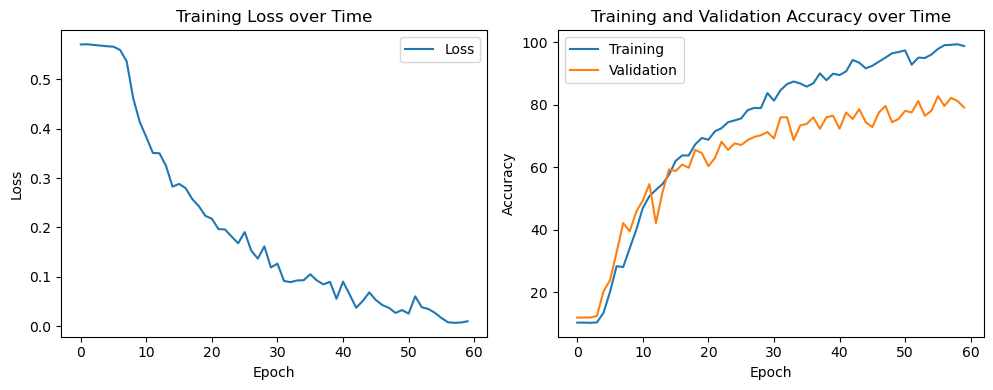

In [65]:
model = ConvNet().to(device)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=64,
        shuffle=True,
        num_workers=19,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2,
        persistent_workers=True,
    )

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=64,
    num_workers=19,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2,
    persistent_workers=True,
)

# Train the model
result = train(model, train_loader, val_loader, num_epochs=60)

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

Hyperparameters: batch size, learning rate, number of epochs

### Part (b) Training Code - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

[Epoch 1, Batch 10] Loss: 2.201
Epoch 1 complete.
Training Accuracy: 11.66%
Validation Accuracy: 10.94%
[Epoch 2, Batch 10] Loss: 2.201
Epoch 2 complete.
Training Accuracy: 11.48%
Validation Accuracy: 10.94%
[Epoch 3, Batch 10] Loss: 2.198
Epoch 3 complete.
Training Accuracy: 11.24%
Validation Accuracy: 10.94%
[Epoch 4, Batch 10] Loss: 2.201
Epoch 4 complete.
Training Accuracy: 11.12%
Validation Accuracy: 10.94%
[Epoch 5, Batch 10] Loss: 2.197
Epoch 5 complete.
Training Accuracy: 11.48%
Validation Accuracy: 10.94%
[Epoch 6, Batch 10] Loss: 2.201
Epoch 6 complete.
Training Accuracy: 11.30%
Validation Accuracy: 10.94%
[Epoch 7, Batch 10] Loss: 2.200
Epoch 7 complete.
Training Accuracy: 11.66%
Validation Accuracy: 10.94%
[Epoch 8, Batch 10] Loss: 2.197
Epoch 8 complete.
Training Accuracy: 11.66%
Validation Accuracy: 10.94%
[Epoch 9, Batch 10] Loss: 2.201
Epoch 9 complete.
Training Accuracy: 11.60%
Validation Accuracy: 10.94%
[Epoch 10, Batch 10] Loss: 2.198
Epoch 10 complete.
Training Acc

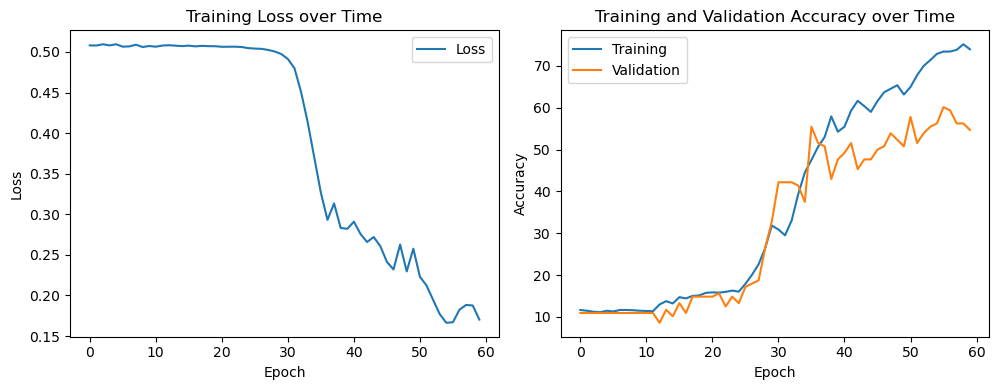

In [66]:
# hyperparameters to tune: batch size, learning rate and the number of epochs
model = ConvNet().to(device)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=128,
        shuffle=True,
        num_workers=19,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2,
        persistent_workers=True,
    )

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=128,
    num_workers=19,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2,
    persistent_workers=True,
)

# Train the model
_ = train(model, train_loader, val_loader, num_epochs=60)

[Epoch 1, Batch 10] Loss: 2.200
[Epoch 1, Batch 20] Loss: 2.187
Epoch 1 complete.
Training Accuracy: 13.02%
Validation Accuracy: 14.58%
[Epoch 2, Batch 10] Loss: 2.317
[Epoch 2, Batch 20] Loss: 2.208
Epoch 2 complete.
Training Accuracy: 12.27%
Validation Accuracy: 10.42%
[Epoch 3, Batch 10] Loss: 2.199
[Epoch 3, Batch 20] Loss: 2.202
Epoch 3 complete.
Training Accuracy: 10.65%
Validation Accuracy: 9.38%
[Epoch 4, Batch 10] Loss: 2.201
[Epoch 4, Batch 20] Loss: 2.199
Epoch 4 complete.
Training Accuracy: 11.05%
Validation Accuracy: 11.46%
[Epoch 5, Batch 10] Loss: 2.200
[Epoch 5, Batch 20] Loss: 2.198
Epoch 5 complete.
Training Accuracy: 10.82%
Validation Accuracy: 13.02%
[Epoch 6, Batch 10] Loss: 2.200
[Epoch 6, Batch 20] Loss: 2.203
Epoch 6 complete.
Training Accuracy: 11.57%
Validation Accuracy: 14.58%
[Epoch 7, Batch 10] Loss: 2.194
[Epoch 7, Batch 20] Loss: 2.158
Epoch 7 complete.
Training Accuracy: 18.23%
Validation Accuracy: 22.92%
[Epoch 8, Batch 10] Loss: 1.943
[Epoch 8, Batch 2

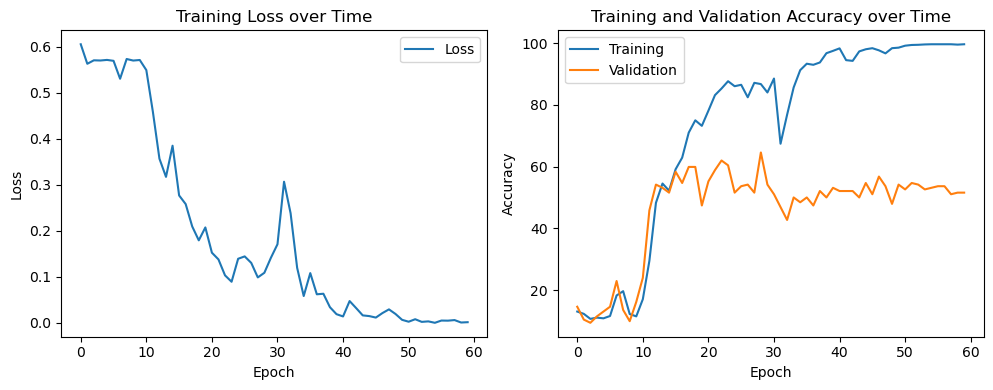

In [68]:
# hyperparameters to tune: batch size, learning rate and the number of epochs
model = ConvNet().to(device)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=64,
        shuffle=True,
        num_workers=19,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2,
        persistent_workers=True,
    )

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=64,
    num_workers=19,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2,
    persistent_workers=True,
)

# Train the model
_ = train(model, train_loader, val_loader, num_epochs=60, lr=0.1)

[Epoch 1, Batch 10] Loss: 2.200
[Epoch 1, Batch 20] Loss: 2.199
Epoch 1 complete.
Training Accuracy: 10.82%
Validation Accuracy: 14.58%
[Epoch 2, Batch 10] Loss: 2.199
[Epoch 2, Batch 20] Loss: 2.197
Epoch 2 complete.
Training Accuracy: 10.53%
Validation Accuracy: 14.58%
[Epoch 3, Batch 10] Loss: 2.199
[Epoch 3, Batch 20] Loss: 2.200
Epoch 3 complete.
Training Accuracy: 10.71%
Validation Accuracy: 14.58%
[Epoch 4, Batch 10] Loss: 2.197
[Epoch 4, Batch 20] Loss: 2.199
Epoch 4 complete.
Training Accuracy: 10.71%
Validation Accuracy: 14.58%
[Epoch 5, Batch 10] Loss: 2.198
[Epoch 5, Batch 20] Loss: 2.197
Epoch 5 complete.
Training Accuracy: 11.17%
Validation Accuracy: 9.90%
[Epoch 6, Batch 10] Loss: 2.198
[Epoch 6, Batch 20] Loss: 2.192
Epoch 6 complete.
Training Accuracy: 14.99%
Validation Accuracy: 20.31%
[Epoch 7, Batch 10] Loss: 2.194
[Epoch 7, Batch 20] Loss: 2.193
Epoch 7 complete.
Training Accuracy: 20.49%
Validation Accuracy: 18.23%
[Epoch 8, Batch 10] Loss: 2.194
[Epoch 8, Batch 2

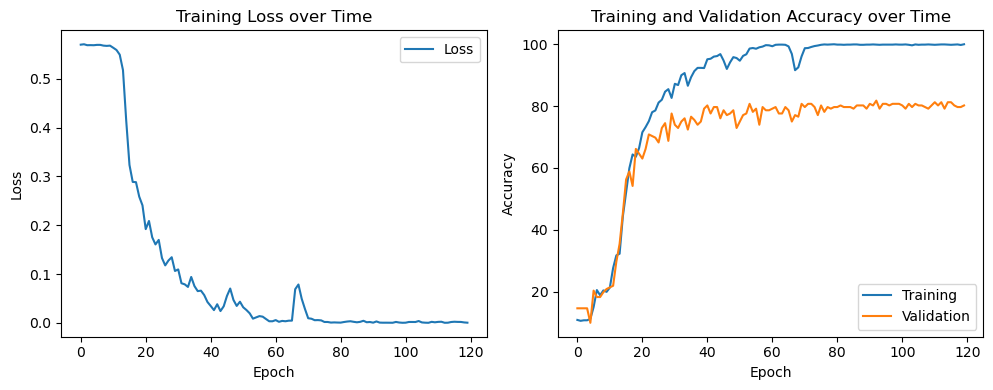

In [70]:
# hyperparameters to tune: batch size, learning rate and the number of epochs
model = ConvNet().to(device)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=64,
        shuffle=True,
        num_workers=19,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2,
        persistent_workers=True,
    )

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=64,
    num_workers=19,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2,
    persistent_workers=True,
)

# Train the model
_ = train(model, train_loader, val_loader, num_epochs=120)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
# The best model is the original one, as it achieves the highest validation accuracy, and the accuracy cannot be further improved by increasing the number of epochs.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [71]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=64,
    num_workers=19,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2,
    persistent_workers=True,
)

# Test the model, use the latest model with 120 epochs 
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 84.90%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [88]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True).to(device)

/home/maxzhang/miniconda3/envs/APS360/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maxzhang/miniconda3/envs/APS360/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [78]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
train_data_tensor = torch.stack([img for img, _ in train_data], dim=0)

In [80]:
features = alexnet.features(train_data_tensor)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [82]:
torch.save(features, "features.pt")

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [84]:
class AlexNetModel(nn.Module):
    def __init__(self):
        super(AlexNetModel, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)  # Replace num_classes with actual number

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [87]:
# features = ... load precomputed alexnet.features(img) ...
model = AlexNetModel()
output = model(features)
prob = F.softmax(output)
prob.shape

/tmp/ipykernel_1606/14067434.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(output)


torch.Size([1775, 9])

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [93]:
# tensor = torch.from_numpy(tensor.detach().numpy())

def train_transfer(model, train_loader, val_loader, num_epochs=10, plot=True, lr=0.001, momentum=0.9):

    # Create data loaders
    # Setup data
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for i, (images, labels) in enumerate(train_loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            features = alexnet.features(images)
            outputs = model(features.detach())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Print statistics
            running_loss += loss.item()

            if i % 10 == 9:  # Print every 10 mini-batches
                print(
                    f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.3f}"
                )
                running_loss = 0.0

        # Calculate and store training metrics
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                features = alexnet.features(images)
                outputs = model(features.detach())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate and store validation accuracy
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
    
    # plot the training curve
    if plot:
        plt.figure(figsize=(15, 4))

        # Plot training loss
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label="Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Time")
        plt.legend()

        # Plot both training and validation accuracies
        plt.subplot(1, 3, 2)
        plt.plot(train_accuracies, label="Training")
        plt.plot(val_accuracies, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

[Epoch 1, Batch 10] Loss: 2.189
[Epoch 1, Batch 20] Loss: 2.103
[Epoch 2, Batch 10] Loss: 1.828
[Epoch 2, Batch 20] Loss: 1.608
[Epoch 3, Batch 10] Loss: 1.280
[Epoch 3, Batch 20] Loss: 1.082
[Epoch 4, Batch 10] Loss: 0.861
[Epoch 4, Batch 20] Loss: 0.800
[Epoch 5, Batch 10] Loss: 0.662
[Epoch 5, Batch 20] Loss: 0.589
[Epoch 6, Batch 10] Loss: 0.501
[Epoch 6, Batch 20] Loss: 0.473
[Epoch 7, Batch 10] Loss: 0.427
[Epoch 7, Batch 20] Loss: 0.426
[Epoch 8, Batch 10] Loss: 0.384
[Epoch 8, Batch 20] Loss: 0.331
[Epoch 9, Batch 10] Loss: 0.332
[Epoch 9, Batch 20] Loss: 0.268
[Epoch 10, Batch 10] Loss: 0.266
[Epoch 10, Batch 20] Loss: 0.300
[Epoch 11, Batch 10] Loss: 0.260
[Epoch 11, Batch 20] Loss: 0.248
[Epoch 12, Batch 10] Loss: 0.232
[Epoch 12, Batch 20] Loss: 0.211
[Epoch 13, Batch 10] Loss: 0.205
[Epoch 13, Batch 20] Loss: 0.183
[Epoch 14, Batch 10] Loss: 0.181
[Epoch 14, Batch 20] Loss: 0.170
[Epoch 15, Batch 10] Loss: 0.171
[Epoch 15, Batch 20] Loss: 0.170
[Epoch 16, Batch 10] Loss: 0

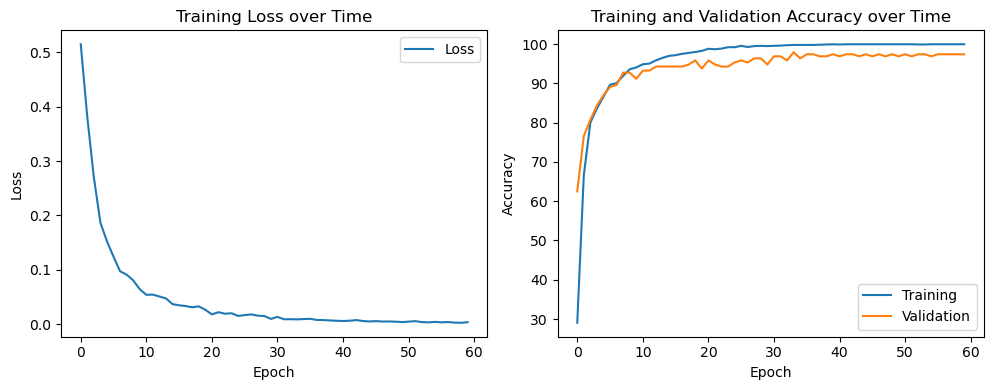

In [94]:
# run with default hyperparameters
model = AlexNetModel().to(device)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=64,
        shuffle=True,
        num_workers=19,
        pin_memory=True,
        drop_last=True,
        prefetch_factor=2,
        persistent_workers=True,
    )

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=64,
    num_workers=19,
    pin_memory=True,
    drop_last=True,
    prefetch_factor=2,
    persistent_workers=True,
)

# Train the model
train_transfer(model, train_loader, val_loader, num_epochs=60)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [95]:
# The one with the alexnet is a lot better